## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
# 載入必須使用的 Library
import keras
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'


Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train
x_test, y_test = test

num_classes = len(np.unique(y_train))

In [3]:
## 資料前處理
def preproc_x(x, flatten=False):
    x = x.astype('float32') / 255.0
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train, num_classes)
y_test = preproc_y(y_test, num_classes)

In [5]:
def build_mlp():
    # build our CNN model, 多加幾層
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    #print(model.summary())
    return model

In [6]:
## 超參數設定
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 100
BATCH_SIZE = 256
MOMENTUM = 0.95
results = {}

#使用迴圈，建立不同 Learning rate 的模型並訓練
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


    model_history = model.fit(x=x_train, y=y_train,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS, shuffle=True,
                                    verbose=1,
                                    validation_data=[x_test, y_test],
                                    callbacks=[es,mc])
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

Experiment with LR = 0.100000
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 6s 113us/step - loss: 2.6178 - acc: 0.2528 - val_loss: 9.9082 - val_acc: 0.1033

Epoch 00001: val_acc improved from -inf to 0.10330, saving model to best_model.h5
Epoch 2/100
50000/50000 [==============================] - 4s 82us/step - loss: 1.8930 - acc: 0.3508 - val_loss: 3.1124 - val_acc: 0.1200

Epoch 00002: val_acc improved from 0.10330 to 0.12000, saving model to best_model.h5
Epoch 3/100
50000/50000 [==============================] - 4s 87us/step - loss: 1.9978 - acc: 0.3432 - val_loss: 2.1727 - val_acc: 0.2599

Epoch 00003: val_acc improved from 0.12000 to 0.25990, saving model to best_model.h5
Epoch 4/100
50000/50000 [==============================] - 4s 82us/step - loss: 1.9549 - acc: 0.3342 - val_loss: 2.0872 - val_acc: 0.3086

Epoch 00004: val_acc improved from 0.25990 to 0.30860, saving model to best_model.h5
Epoch 5/100
50000/50000 [=


Epoch 00039: val_acc did not improve from 0.72080
Epoch 40/100
50000/50000 [==============================] - 4s 82us/step - loss: 0.8063 - acc: 0.7168 - val_loss: 0.7631 - val_acc: 0.7366

Epoch 00040: val_acc improved from 0.72080 to 0.73660, saving model to best_model.h5
Epoch 41/100
50000/50000 [==============================] - 4s 79us/step - loss: 0.7940 - acc: 0.7200 - val_loss: 0.8035 - val_acc: 0.7153

Epoch 00041: val_acc did not improve from 0.73660
Epoch 42/100
50000/50000 [==============================] - 5s 90us/step - loss: 0.7867 - acc: 0.7238 - val_loss: 0.7792 - val_acc: 0.7280

Epoch 00042: val_acc did not improve from 0.73660
Epoch 43/100
50000/50000 [==============================] - 4s 87us/step - loss: 0.7940 - acc: 0.7228 - val_loss: 0.9462 - val_acc: 0.6829

Epoch 00043: val_acc did not improve from 0.73660
Epoch 00043: early stopping
Experiment with LR = 0.010000
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [=====================

50000/50000 [==============================] - 4s 80us/step - loss: 1.6564 - acc: 0.4397 - val_loss: 1.3382 - val_acc: 0.5207

Epoch 00011: val_acc improved from 0.50070 to 0.52070, saving model to best_model.h5
Epoch 12/100
50000/50000 [==============================] - 4s 82us/step - loss: 1.6112 - acc: 0.4538 - val_loss: 1.4672 - val_acc: 0.4849

Epoch 00012: val_acc did not improve from 0.52070
Epoch 13/100
50000/50000 [==============================] - 4s 83us/step - loss: 1.5761 - acc: 0.4618 - val_loss: 1.3351 - val_acc: 0.5245

Epoch 00013: val_acc improved from 0.52070 to 0.52450, saving model to best_model.h5
Epoch 14/100
50000/50000 [==============================] - 4s 79us/step - loss: 1.5447 - acc: 0.4693 - val_loss: 1.2764 - val_acc: 0.5465

Epoch 00014: val_acc improved from 0.52450 to 0.54650, saving model to best_model.h5
Epoch 15/100
50000/50000 [==============================] - 4s 83us/step - loss: 1.5113 - acc: 0.4809 - val_loss: 1.2525 - val_acc: 0.5580

Epoch 00

50000/50000 [==============================] - 4s 79us/step - loss: 2.7760 - acc: 0.2236 - val_loss: 1.9730 - val_acc: 0.3005

Epoch 00008: val_acc improved from 0.28570 to 0.30050, saving model to best_model.h5
Epoch 9/100
50000/50000 [==============================] - 4s 79us/step - loss: 2.7388 - acc: 0.2282 - val_loss: 1.9434 - val_acc: 0.3091

Epoch 00009: val_acc improved from 0.30050 to 0.30910, saving model to best_model.h5
Epoch 10/100
50000/50000 [==============================] - 4s 83us/step - loss: 2.6876 - acc: 0.2379 - val_loss: 1.9239 - val_acc: 0.3178

Epoch 00010: val_acc improved from 0.30910 to 0.31780, saving model to best_model.h5
Epoch 11/100
50000/50000 [==============================] - 4s 82us/step - loss: 2.6488 - acc: 0.2432 - val_loss: 1.8836 - val_acc: 0.3282

Epoch 00011: val_acc improved from 0.31780 to 0.32820, saving model to best_model.h5
Epoch 12/100
50000/50000 [==============================] - 4s 80us/step - loss: 2.5893 - acc: 0.2520 - val_loss: 

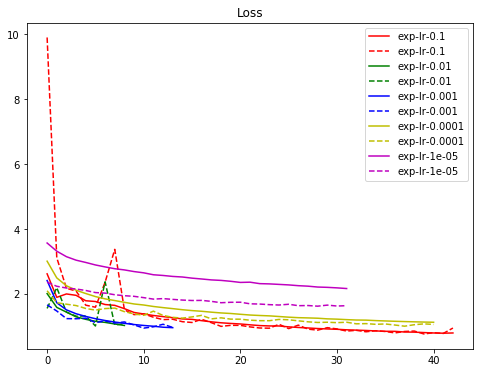

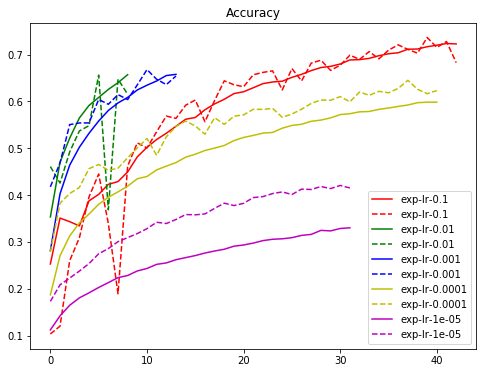

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()